In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Conv1D

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
df_distinct_stacks['listStackTrace'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.split('\n'))
corpus = df_distinct_stacks['listStackTrace'].tolist()
frames = pd.Series(list(set([elt for l in corpus for elt in l])))
df_frames = pd.DataFrame()
df_frames['frame'] = pd.get_dummies(frames).T.reset_index().rename(columns={'index': 'frame'})['frame']
df_frames['embedding'] = pd.get_dummies(frames).T.reset_index().apply(lambda x : x[1:].values, axis = 1)
df_distinct_stacks['rankFrames'] = df_distinct_stacks['listStackTrace'].apply(lambda x : index_frame(x, df_frames))

In [7]:
df_levenshtein = pd.DataFrame()
df_levenshtein['Levensh'] = df_measures['Levensh']
df_levenshtein['stack1'] = df_levenshtein.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[0], axis = 1)
df_levenshtein['stack2'] = df_levenshtein.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[1], axis = 1)

In [8]:
embeddings = 1 * np.random.randn(df_frames.shape[0] + 1, df_frames['embedding'][0].shape[0])
embeddings[0] = 0
embeddings[1:] = np.vstack(df_frames['embedding'].tolist())
embeddings.shape

(2251, 2250)

In [9]:
X = df_levenshtein[['stack1','stack2']]
Y = df_levenshtein['Levensh']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2)

max_length = df_distinct_stacks['listStackTrace'].apply(lambda x : len(x)).max()
X_train = padding(X_train, max_length)
X_validation = padding(X_validation, max_length)

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

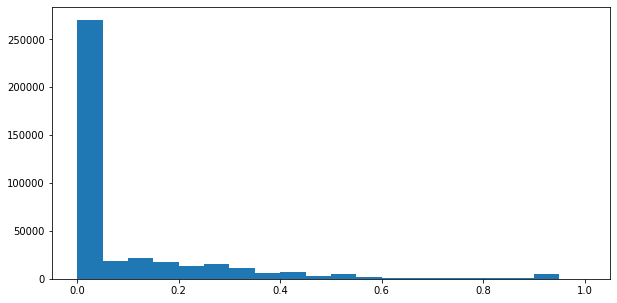

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

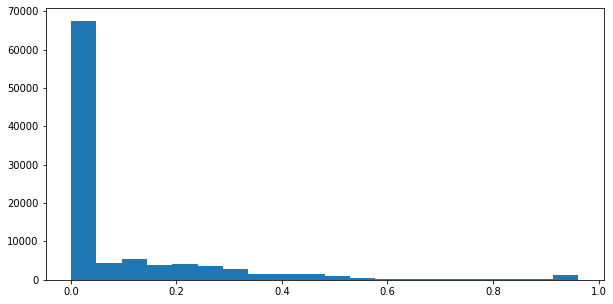

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

<div>
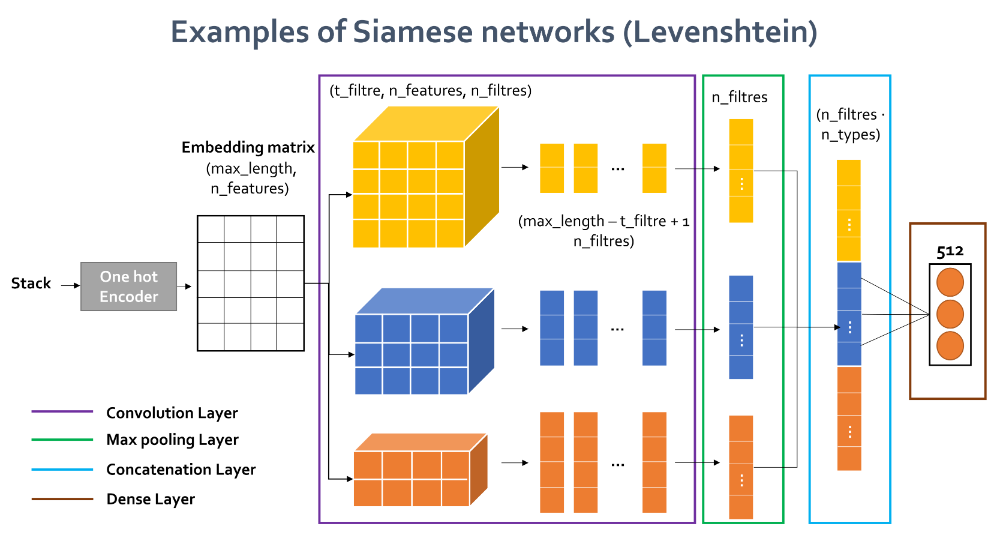
<div>

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
input_tensor = Input(shape = (max_length,))
input_layer = (Embedding(len(embeddings), df_frames.shape[0], weights=[embeddings], input_shape=(max_length,), trainable=False))(input_tensor)
submodels = []
for kw in (3,4) :
    conv_layer = Conv1D(1024, kw, activation='tanh')(input_layer)
    maxpool_layer = GlobalMaxPooling1D()(conv_layer)
    submodels.append(maxpool_layer)
conc_layer = concatenate(submodels, axis=1)
dense_layer = Dense(size_hash_vector, activation = 'tanh')(conc_layer)
x = Sequential()
x.add(Model(inputs = input_tensor, outputs = dense_layer))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (max_length,)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = False, print_summary = False)

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 300s 379ms/step - loss: -0.4696 - manh_dist_loss: 0.0487 - abs_vect_loss: -0.9875 - abs_vect_1_loss: -0.9882 - manh_dist_rmse: 0.2207 - manh_dist_mae: 0.1586 - val_loss: -0.4813 - val_manh_dist_loss: 0.0281 - val_abs_vect_loss: -0.9903 - val_abs_vect_1_loss: -0.9911 - val_manh_dist_rmse: 0.1676 - val_manh_dist_mae: 0.1264
Epoch 2/20
781/781 [==============================] - 295s 378ms/step - loss: -0.4828 - manh_dist_loss: 0.0259 - abs_vect_loss: -0.9911 - abs_vect_1_loss: -0.9917 - manh_dist_rmse: 0.1609 - manh_dist_mae: 0.1214 - val_loss: -0.4833 - val_manh_dist_loss: 0.0251 - val_abs_vect_loss: -0.9914 - val_abs_vect_1_loss: -0.9919 - val_manh_dist_rmse: 0.1584 - val_manh_dist_mae: 0.1192
Epoch 3/20
781/781 [==============================] - 295s 378ms/step - loss: -0.4837 - manh_dist_loss: 0.0244 - abs_vect_loss: -0.9915 - abs_vect_1_loss: -0.9921 - manh_dist_rmse: 0.1561 - manh_dist_mae: 0.1176 - val_loss: -0.4835 - val_manh_d

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

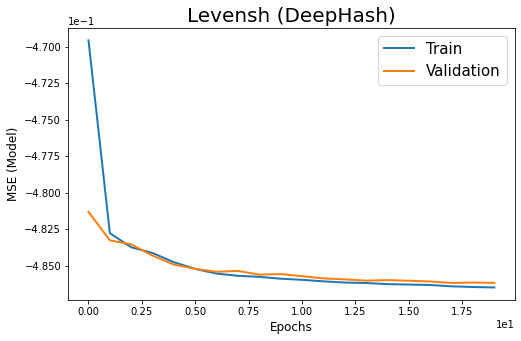

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Levensh (Baseline)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Hash preserving loss

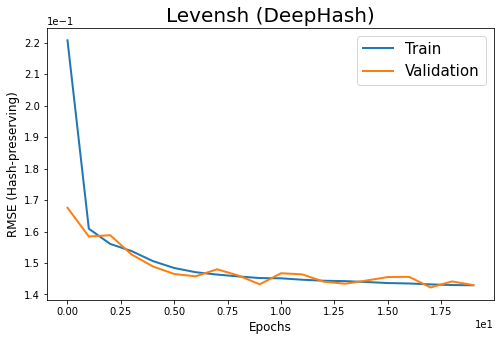

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Levensh (Baseline)', fontsize = 20)
plt.ylabel('RMSE (Hash-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of Hash preserving loss

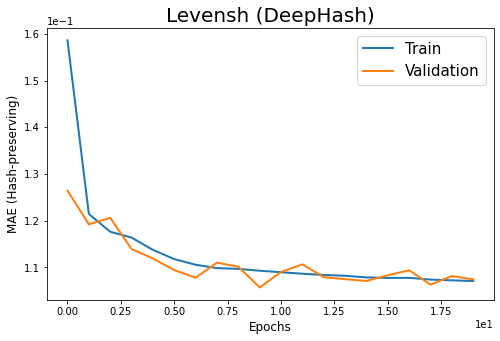

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Levensh (Baseline)', fontsize = 20)
plt.ylabel('MAE (Hash-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.769, 0.231, 0.407, 0.174, 0.028, 0.045, 0.151, 0.147, 0.2  ,
       0.168, 0.172, 0.305, 0.051, 0.247, 0.35 , 0.256, 0.309, 0.032,
       0.406, 0.282, 0.387, 0.364, 0.017, 0.018, 0.015, 0.265, 0.234,
       0.131, 0.437, 0.101, 0.127, 0.335, 0.206, 0.093, 0.168, 0.956,
       0.195, 0.033, 0.168, 0.38 , 0.239, 0.191, 0.24 , 0.01 , 0.633,
       0.883, 0.201, 0.027, 0.204, 0.95 ], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.2  , 0.059, 0.   , 0.   , 0.   , 0.   , 0.095, 0.   , 0.   ,
       0.   , 0.   , 0.19 , 0.   , 0.   , 0.28 , 0.   , 0.167, 0.   ,
       0.348, 0.263, 0.211, 0.294, 0.   , 0.   , 0.   , 0.   , 0.08 ,
       0.   , 0.409, 0.   , 0.   , 0.263, 0.   , 0.   , 0.   , 0.938,
       0.   , 0.   , 0.13 , 0.35 , 0.158, 0.   , 0.   , 0.   , 0.125,
       0.833, 0.   , 0.   , 0.087, 0.938])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

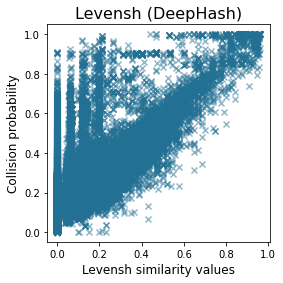

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Levensh (Baseline)', fontsize = 16)
plt.xlabel("Levensh similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/Levensh-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.7414845158162271

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.6074592405376177

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 0
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer, True, input_tensor)

In [32]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-deep-hash.model/assets


In [ ]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [33]:
intermediate_model.predict(padding(X.iloc[[11]], max_length)['stack_1'])[0][:32]

array([ 0.74532753,  0.7517992 ,  0.7714825 ,  0.6768422 , -0.8089838 ,
       -0.76376224,  0.76823765, -0.8159833 , -0.71280736, -0.8639172 ,
        0.97652745, -0.6902948 ,  0.71201885, -0.72049683,  0.8422985 ,
        0.86168385,  0.72359127, -0.81265646, -0.7399015 ,  0.9044673 ,
        0.8547649 , -0.7881113 ,  0.70535445,  0.86295193,  0.7469961 ,
       -0.9177066 , -0.68387586, -0.7163068 ,  0.71759874,  0.63831085,
       -0.74484855,  0.8027513 ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [34]:
hash_vectors = intermediate_model.predict(pad_sequences(df_distinct_stacks['rankFrames'], padding = 'post', truncating = 'post', maxlen = 29)) 

In [35]:
np.mean(np.abs(hash_vectors))

0.6986184

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [36]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.0007080078125

### 3.3.4. Comparison between approximate hamming and real hamming

In [37]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

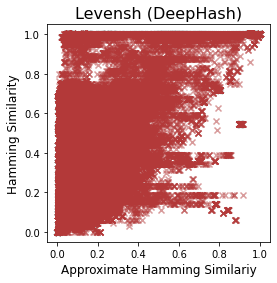

In [38]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Levensh (Baseline)', fontsize = 16)
plt.savefig('Results/Baseline/Levensh-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [39]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [40]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


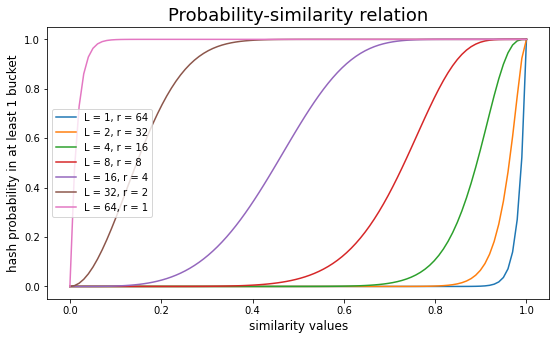

In [41]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [42]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Levensh', trace = False)

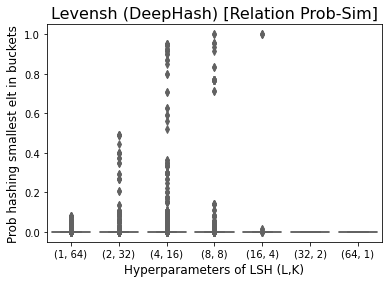

In [43]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Levensh (Baseline) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/Baseline/Levensh-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [44]:
'Exemple, L = K = 8'
L, K = params[2]
L, K

(4, 16)

In [ ]:
df_probLSH.mean()['(4, 16)']

In [ ]:
df_probLSH.median()['(4, 16)']

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [45]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [46]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [47]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

133

In [48]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{4,
 5,
 17,
 26,
 76,
 77,
 80,
 88,
 92,
 93,
 102,
 104,
 105,
 106,
 120,
 126,
 128,
 129,
 133,
 137,
 160,
 162,
 177,
 224,
 236,
 269,
 271,
 298,
 303,
 327,
 330,
 334,
 339,
 343,
 345,
 347,
 358,
 396,
 398,
 402,
 425,
 432,
 447,
 486,
 503,
 515,
 519,
 521,
 534,
 539,
 543,
 562,
 564,
 632,
 644,
 655,
 677,
 682,
 688,
 692,
 715,
 732,
 765,
 797,
 805,
 807,
 825,
 826,
 829,
 836,
 854,
 865,
 870,
 887,
 890,
 901,
 908,
 910,
 911,
 932,
 945,
 950,
 953,
 975,
 982,
 994,
 997,
 999}

In [49]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [50]:
near_duplicates_sim = df_measures['Levensh'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

88668     0.928571
124224    0.714286
124294    0.714286
84128     0.642857
124351    0.642857
            ...   
124599    0.250000
124300    0.210526
124752    0.200000
73130     0.000000
124820    0.000000
Name: Levensh, Length: 87, dtype: float64

In [51]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Levensh', n_stacks, n_duplicate_pairs)
set_real_nns

{2,
 3,
 4,
 5,
 15,
 17,
 21,
 25,
 26,
 40,
 66,
 77,
 80,
 88,
 92,
 93,
 97,
 102,
 104,
 105,
 106,
 120,
 126,
 137,
 153,
 175,
 177,
 208,
 220,
 224,
 236,
 269,
 271,
 298,
 303,
 315,
 327,
 330,
 334,
 339,
 343,
 347,
 358,
 396,
 398,
 402,
 425,
 432,
 439,
 446,
 486,
 503,
 515,
 519,
 521,
 534,
 539,
 543,
 562,
 564,
 589,
 626,
 632,
 655,
 677,
 682,
 688,
 715,
 732,
 765,
 775,
 805,
 807,
 825,
 854,
 870,
 890,
 901,
 908,
 910,
 911,
 932,
 945,
 950,
 953,
 982,
 997}

In [52]:
real_nns_sim[:n_duplicate_pairs]

88668     0.928571
124224    0.714286
124294    0.714286
124351    0.642857
124132    0.642857
            ...   
92282     0.444444
20880     0.444444
124313    0.437500
124353    0.437500
124720    0.437500
Length: 87, dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [53]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.833

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

-----------------------------------------------------------------

In [54]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.809

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

-----------------------------------------------------------------

In [55]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.7949999999999998

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [ ]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

In [56]:
df_knns = mean_generalized_mrr(n_stacks, params[3:4], hash_vectors_hamming, b, df_measures ,'Levensh', trace = False)
df_knns.mean(skipna = True, axis = 0)

(8, 8)    0.748608
dtype: float64